In [57]:
import nd2
import napari
from PIL import Image
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import math

In [165]:
import pandas as pd
from skimage.draw import line
from skimage.measure import label, regionprops_table
from skimage.transform import rotate

In [34]:
lines = pd.read_csv("real_data/40x_SB5_dilute001_segmented_cell_stacks_for_width.csv")

In [33]:
mask_files = sorted(glob("real_data/40x_SB5_dilute001_segmented//*"))

In [72]:
marked_indexes = lines["axis-0"].unique()

In [136]:
plot = False
avg_cell_widths = []
cell_stack_size = []
for i in marked_indexes:
    masks = (np.array(Image.open(mask_files[int(i)])))
    mask_lines = lines.query("`axis-0` == @i")
    line_indexes = mask_lines["index"].unique()
    if plot:
        plt.figure(figsize=(20,20))
        plt.title(i)
        plt.imshow(masks, cmap = label_cmap, interpolation='none')
    for line_index in line_indexes:
        single_line = lines.query("index == @line_index")
        assert len(single_line) == 2
        
        (y1, x1), (y2, x2) = (single_line.query("`vertex-index` == 0")[["axis-1", "axis-2"]]).iloc[0].tolist(), (single_line.query("`vertex-index` == 1")[["axis-1", "axis-2"]]).iloc[0].tolist()
        if math.isnan(y1):
            pass
        else:
            rr, cc = line(int(y1),int(x1),int(y2),int(x2))
            mask_IDs, mask_counts = np.unique(masks[rr,cc], return_counts=True)
            if 0 in mask_IDs: #Throw away cells touching the edge
                pass
            else:
                filtered_masks = []
                filtered_counts = []
                for mask, count in zip(mask_IDs, mask_counts):
                    if count > 4 and mask != 0:
                        filtered_masks.append(mask)
                        filtered_counts.append(count)
    
                n_cells = len(filtered_masks)
                if n_cells > 3:
                    total_width = sum(filtered_counts)
                    avg_cell_width = total_width / n_cells
                    avg_cell_widths.append(avg_cell_width)
                    cell_stack_size.append(n_cells)
                    if plot:
                        plt.scatter(cc, rr, c = "r", s = 10)
    if plot:
        plt.show()

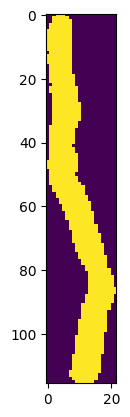

In [158]:
def crop_single_cell(single_cell):
    true_y, true_x = np.where(single_cell)
    
    # Determine the bounding box coordinates
    min_x, max_x = true_x.min(), true_x.max()
    min_y, max_y = true_y.min(), true_y.max()
    
    # Crop the array to the bounding box around the mask
    cropped_single_cell = single_cell[min_y:max_y+1, min_x:max_x+1]
    return cropped_single_cell

cropped_single_cell = crop_single_cell(single_cell)
plt.imshow(cropped_single_cell)

In [178]:
cell_angle = regionprops_table(label(cropped_single_cell), properties = ["orientation"])["orientation"][0]
rotation_angle = np.rad2deg(cell_angle) + 90
rotated_cell = rotate(cropped_single_cell, rotation_angle, resize=True)

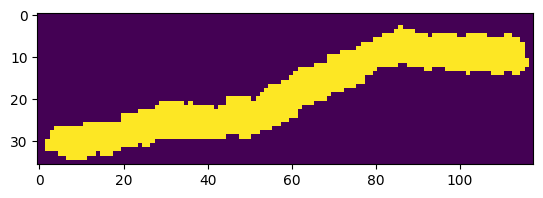

In [179]:
plt.imshow(rotated_cell)

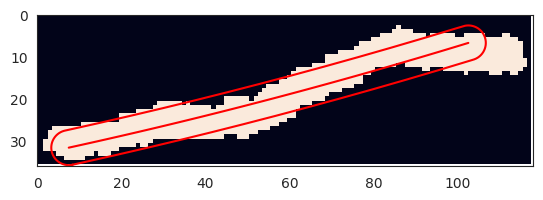

In [199]:
from colicoords import Data, Cell
data = Data()
data.add_data(rotated_cell * 1, 'binary')
cell = Cell(data)
cell.optimize()

from colicoords.plot import CellPlot
import matplotlib.pyplot as plt

cp = CellPlot(cell)

plt.figure()
plt.imshow(rotated_cell)
cp.plot_outline()
cp.plot_midline()
plt.show()


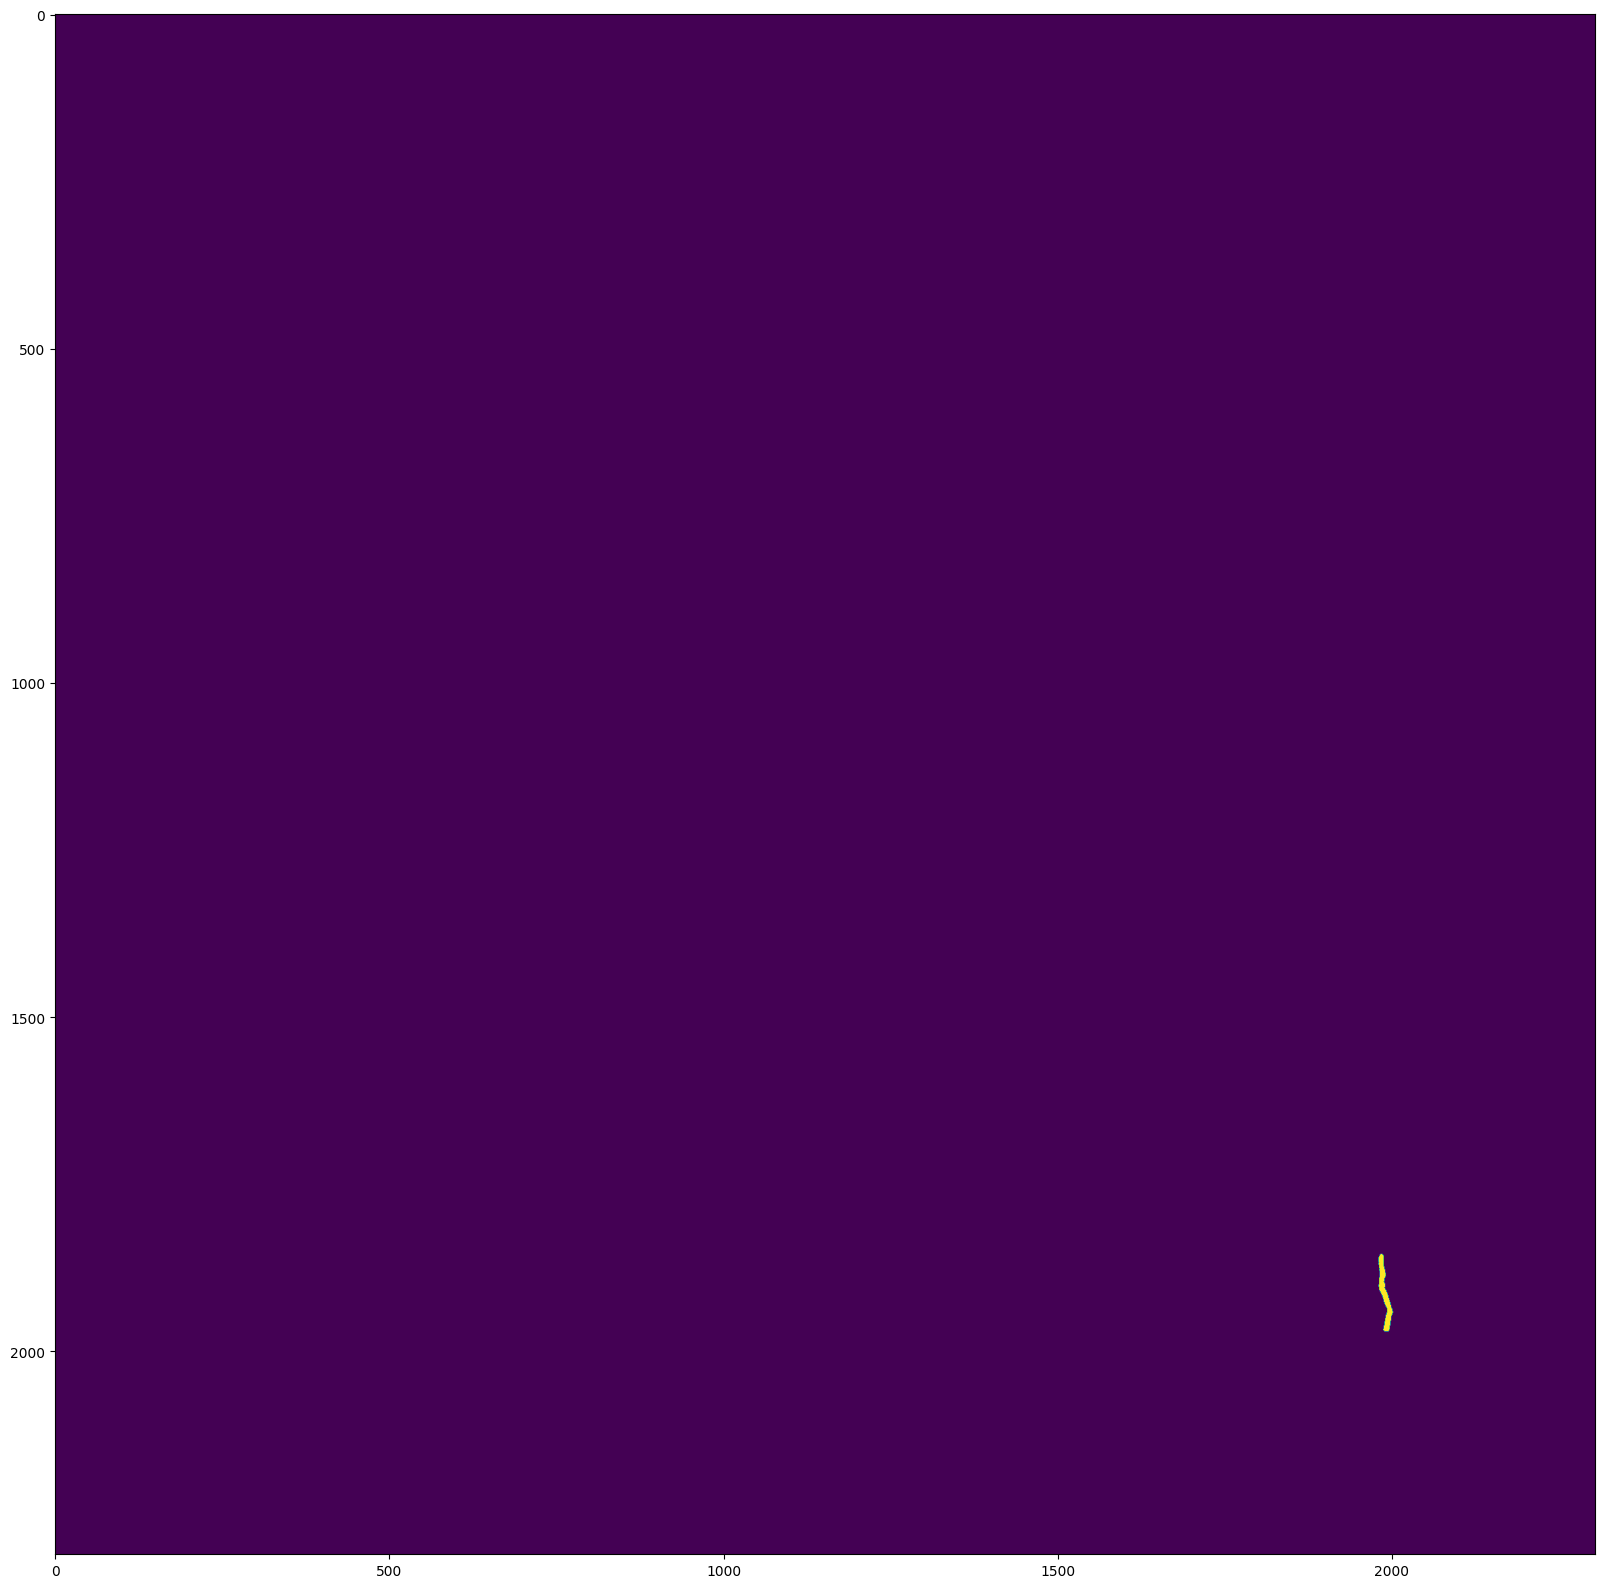

In [151]:
masks = (np.array(Image.open(mask_files[0])))
single_cell = masks == 1405
plt.figure(figsize=(20,20))
plt.imshow(single_cell, interpolation = None)

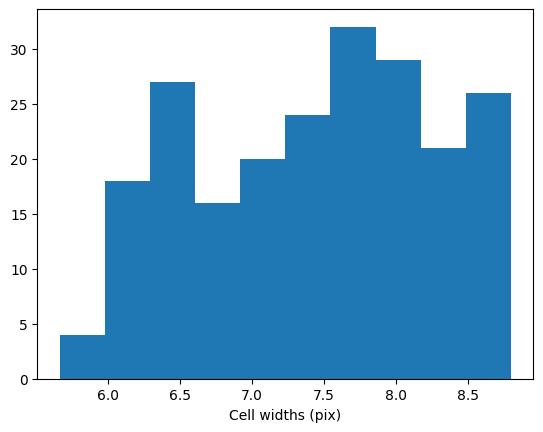

In [137]:
plt.hist(avg_cell_widths)
plt.xlabel("Cell widths (pix)")
plt.show()

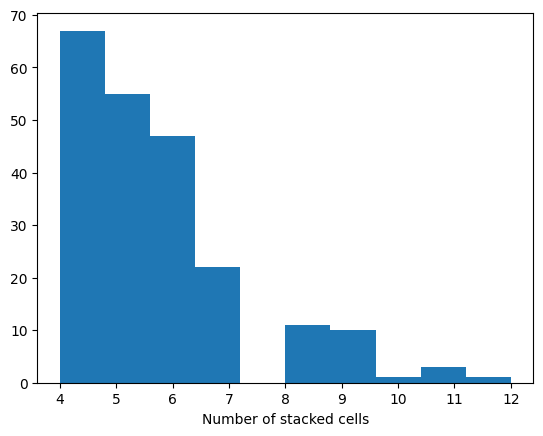

In [138]:
plt.hist(cell_stack_size)
plt.xlabel("Number of stacked cells")
plt.show()

Text(0, 0.5, 'Average cell width (pix)')

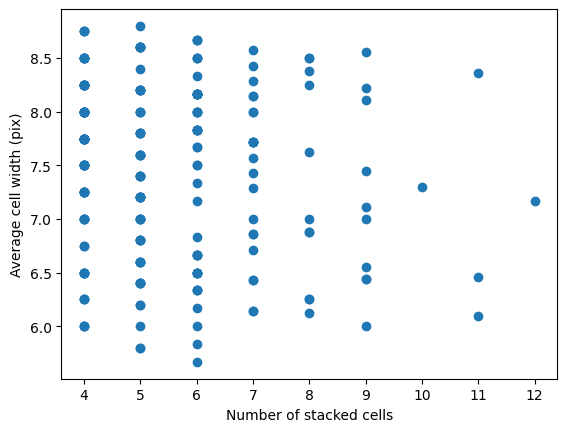

In [139]:
plt.scatter(cell_stack_size, avg_cell_widths)
plt.xlabel("Number of stacked cells")
plt.ylabel("Average cell width (pix)")

In [74]:
(y1, x1), (y2, x2) = (single_line.query("`vertex-index` == 0")[["axis-1", "axis-2"]]).iloc[0].tolist(), (single_line.query("`vertex-index` == 1")[["axis-1", "axis-2"]]).iloc[0].tolist()

In [9]:
clist = napari.utils.colormaps.label_colormap(10_000)
label_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("idk", clist.colors)

In [75]:
mask_IDs, mask_counts = np.unique(masks[rr,cc], return_counts=True)

[2, 2, 9, 8, 7, 7, 8]

In [15]:
avg_cell_width

7.833333333333333

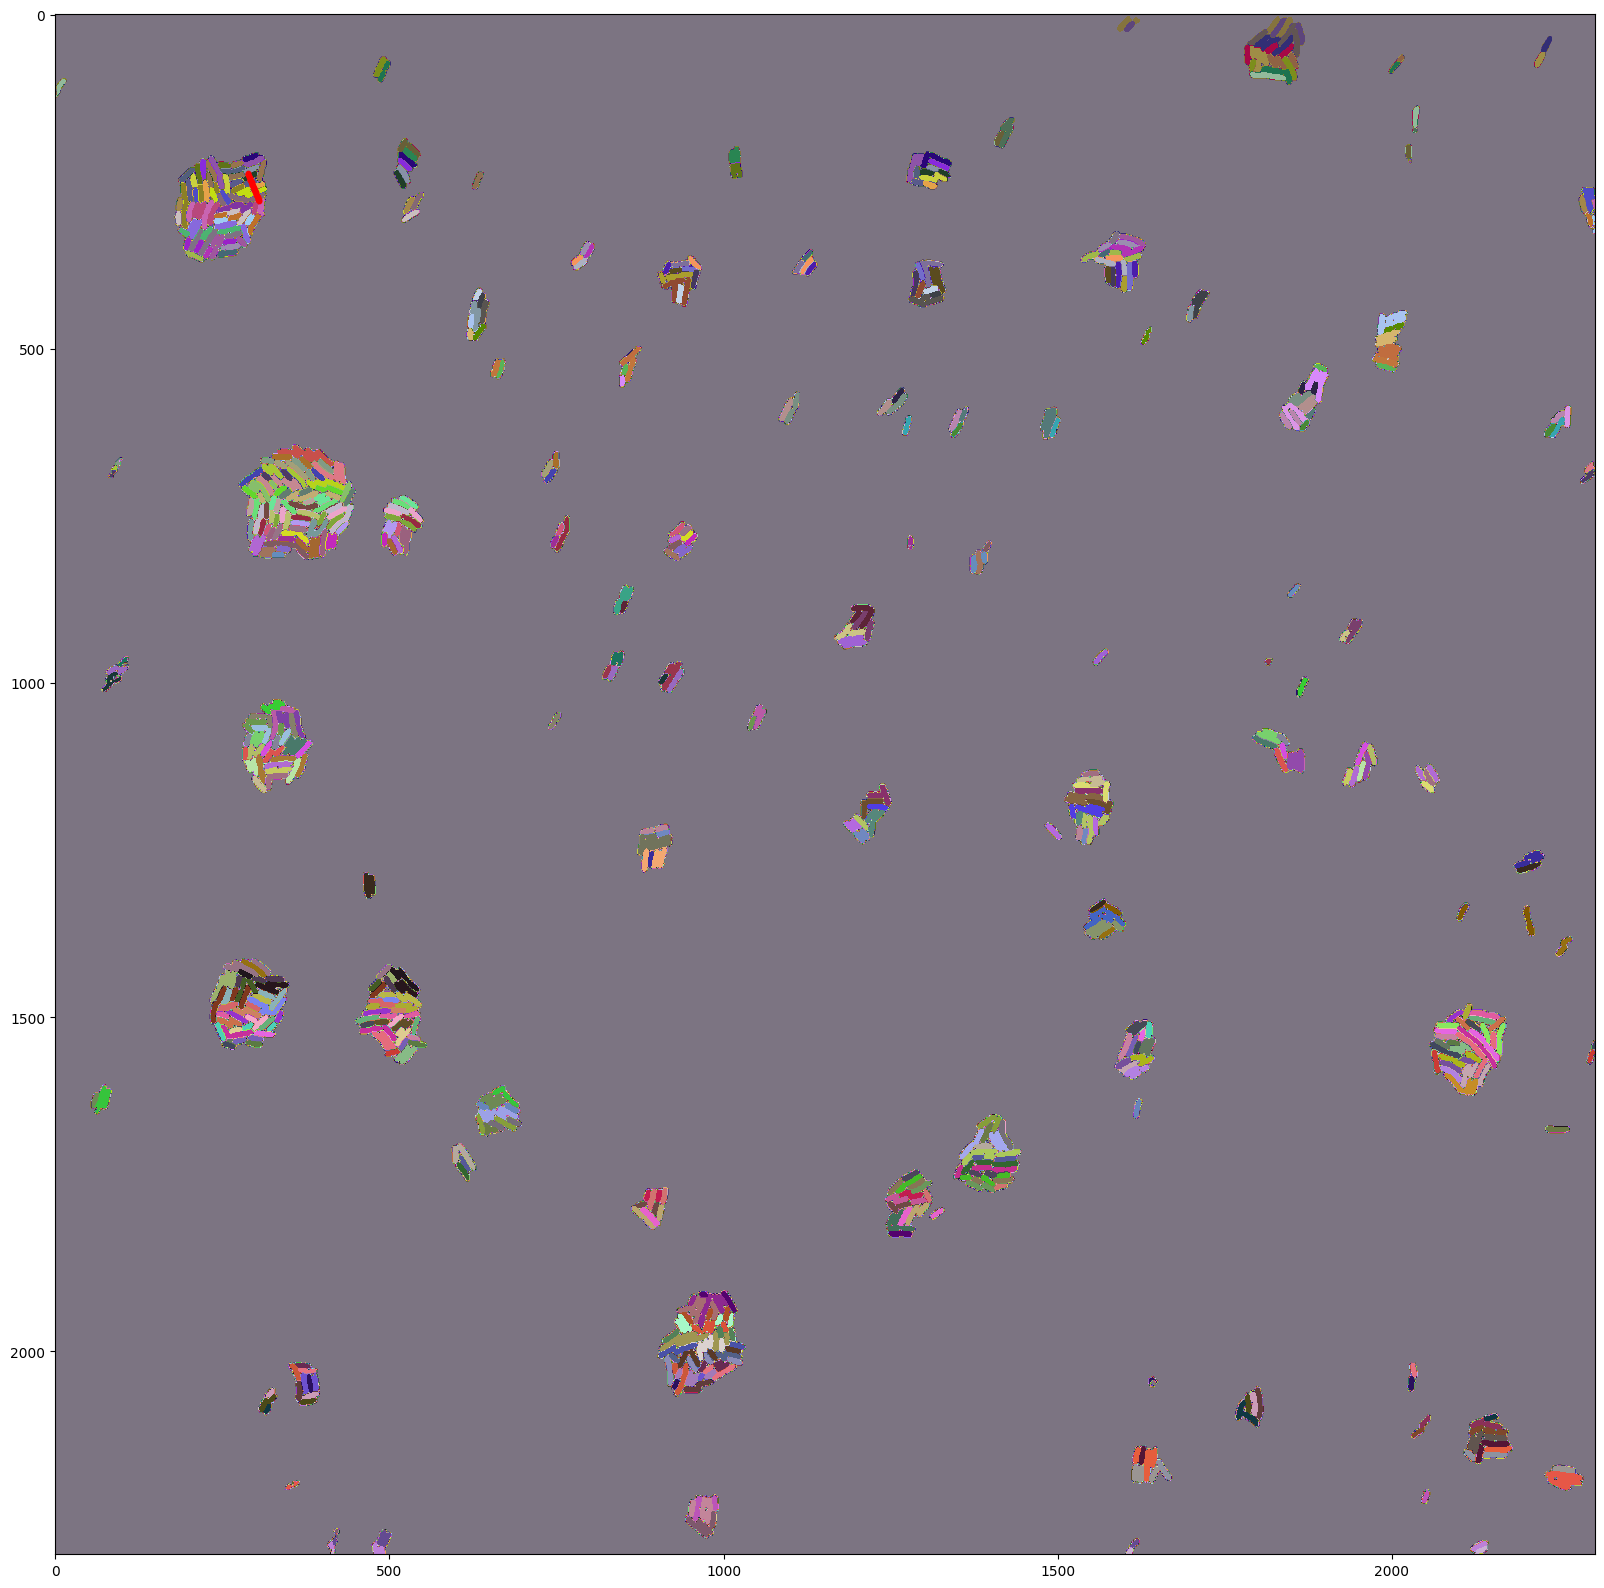

In [77]:
plt.figure(figsize=(20,20))
plt.imshow(masks, cmap = label_cmap)
plt.scatter(cc, rr, c = "r", s = 10)